# Reduce Churning
We are going to create a mock campaign in order to attempt to reduce the churn amount. We are going to target customers at risk of churning, and perform AB testing to see if we can reduce churn amount. Note this is a mock scenario.

## Identifying High Risk Customers
Let's figure out who these high risk customers are. These are customers that the model would predict as "Churn", or those with a churn prediction probability above a certain threshold. For mock sake we will predict on our original dataset to determine the at risk customers. In practical application, this would be done on a new dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

### Load in data

In [ ]:
# Start by loading and preprocessing the data

# Load the data
path = "data/ECommerceDataset.xlsx"
data = pd.read_excel(path, sheet_name="E Comm")

# Preprocess data
# We don't need customerID - it gives our model no benefit
data.drop(columns=["CustomerID"], inplace=True)

# Low percentage of null values
# Fill in null values using median method
for column in data.columns:
  if data[column].isnull().sum() > 0:
    data[column].fillna(data[column].median(), inplace=True)

# Convert column dtype from object to int. X will be used for rf predictions
# We have object data types that we need to encode, let's use label encoder
def encode(x):
  if x.dtype == "object":
    x = LabelEncoder().fit_transform(x)
  return x

# Let's encode our dataset. We will make X and y values for our model
data_encoded = data.apply(lambda x : encode(x))
X = data_encoded.drop(["Churn"], axis=1)
y = data_encoded["Churn"]

### Load in random forest model

In [ ]:
# Now create inputs and target datasets, load model, predict on our data
# Load the model from the file
path = "model/random_forest_classifier.pkl"
rf_classifier = joblib.load(path)

# Make predictions on the test set
y_pred = rf_classifier.predict(X)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
confusion = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)

print("Oversampled Data: \n")
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:')
print(confusion)
print('\nClassification Report:')
print(report)

Oversampled Data: 

Accuracy: 1.00

Confusion Matrix:
[[4667   15]
 [   0  948]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4682
           1       0.98      1.00      0.99       948

    accuracy                           1.00      5630
   macro avg       0.99      1.00      1.00      5630
weighted avg       1.00      1.00      1.00      5630



### Identify high risk customers in our dataset

In [ ]:
# Separate the high risk customers
# Convert y_pred into a series for easier indexing
y_pred_series = pd.Series(y_pred, index=data.index)

# Create a mask for rows where the prediction is 1
mask = y_pred_series == 1

# Use the mask to filter rows in `X`
high_risk = data[mask]
high_risk = high_risk.drop(["Churn"], axis=1)
print(f"Amount of users that are high risk: {high_risk.shape[0]}")

Amount of users that are high risk: 963


In [ ]:
high_risk.head()

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,9.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,9.0,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,0.0,Phone,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


Here we have created our high risk dataset

## Defining Campaign Variables

### Look at the correlations

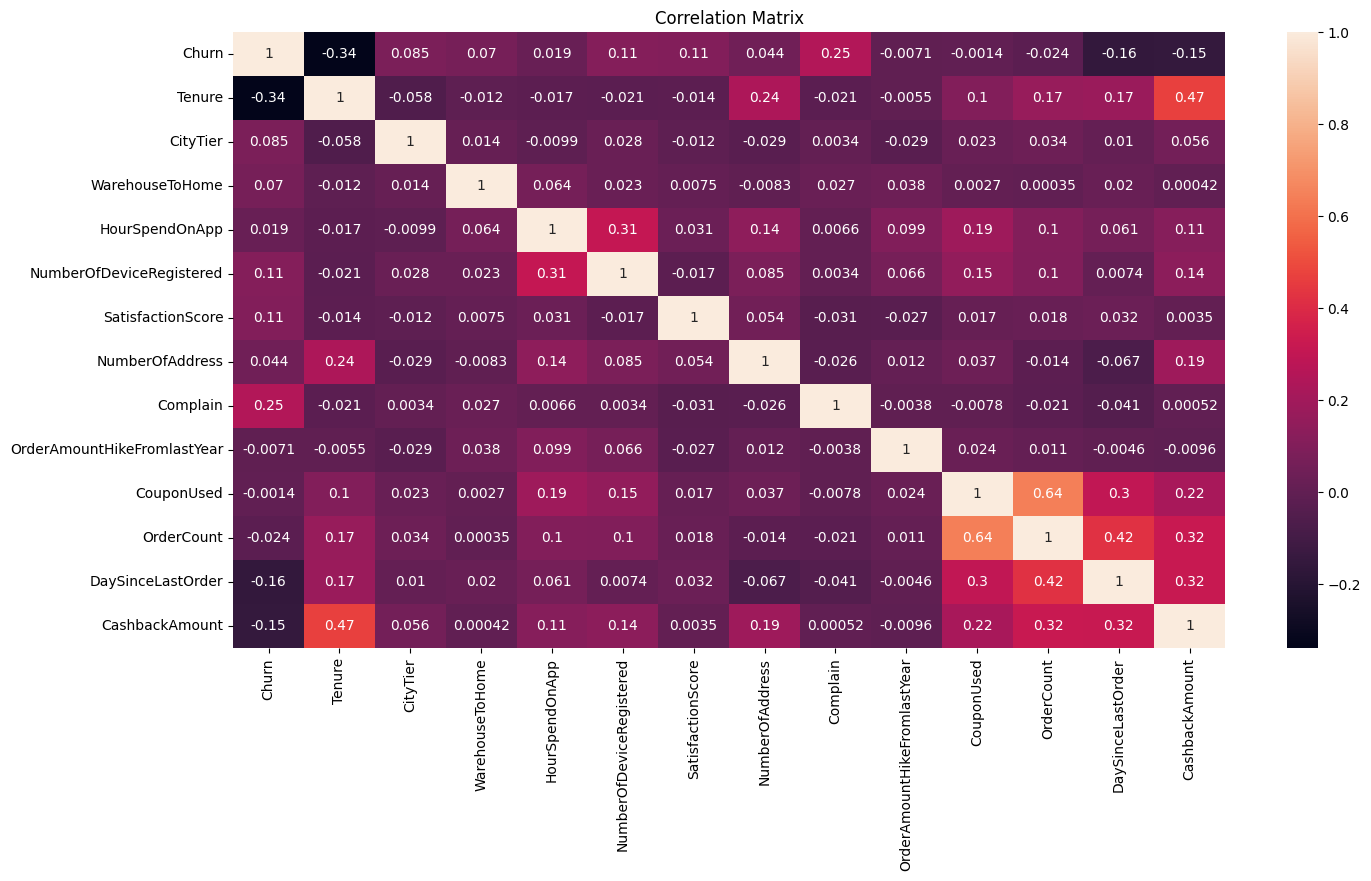

In [ ]:
# Create and view correlation matrix
correlation_matrix = data.corr(numeric_only=True)

# Let's look at a correlation heatmap of the data
plt.figure(figsize=(16,8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Extract correlations with 'Churn', sort by absolute value in descending order
churn_correlations = correlation_matrix['Churn'].drop('Churn', axis=0)
sorted_correlations = churn_correlations.abs().sort_values(ascending=False)

# Print the sorted correlations
print("Variables in order of absolute correlation with churn:")
print(sorted_correlations)

Variables in order of absolute correlation with churn:
Tenure                         0.337831
Complain                       0.250188
DaySinceLastOrder              0.155871
CashbackAmount                 0.154118
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
CityTier                       0.084703
WarehouseToHome                0.069544
NumberOfAddress                0.043931
OrderCount                     0.024038
HourSpendOnApp                 0.018816
OrderAmountHikeFromlastYear    0.007075
CouponUsed                     0.001430
Name: Churn, dtype: float64


### Consider variables

Here we can see that the variable with the highest magnitude of correlation is tenure, aka how much time with the company the customer has.




**Campaign Variables to Consider:**

1. **Tenure-Based Engagement**: High correlation suggests long-term customers are less likely to churn. Design a loyalty program or exclusive offers for customers based on their tenure. Celebrate anniversary milestones with the brand to make long-standing customers feel valued.

2. **Addressing Complaints Proactively**: With a significant correlation, focus on improving the complaint resolution process. A campaign could involve reaching out to customers who have had issues in the past with personalized apologies and offers that address their specific grievances.

3. **Re-engagement Based on Inactivity**: DaySinceLastOrder shows a moderate correlation. Target customers who haven't made a purchase recently with re-engagement campaigns, such as "We miss you" emails or special offers to encourage them to make a purchase.

4. **Cashback Incentives**: Since CashbackAmount correlates with churn, consider campaigns that offer increased cashback rewards for a limited time or on specific products that are popular among at-risk customers.


**How to Select Campaign Variables**
* **Customer Insights and Feedback:** Use qualitative data (e.g., customer feedback, reviews) to understand the context behind the numbers. This can help identify specific pain points or desires that can be addressed through targeted campaigns.

* **Test and Learn Approach:** Given the mock scenario, you could simulate different campaign strategies in a controlled environment. Use historical data to model the potential impact of addressing the correlated variables through specific campaigns.

* **Segmentation for Personalization:** Segment your customers not just based on the risk of churn but also based on their behaviors and preferences that relate to the correlated variables. Tailor campaigns to different segments for maximum relevance and impact.

* **Combine Variables for Comprehensive Campaigns**: Instead of focusing on a single variable, consider campaigns that address multiple areas of concern. For example, a re-engagement campaign that offers cashback incentives for customers with high tenure but low recent activity.

## Complaints Mock Campaign - personalised apology with cashback incentive for complaints in high risk category.

In this campaign we will personalise an apology for each complaint in the high risk category, and include a cashback incentive for their next order.

Our key performance indicator (KPI) will be based on reduction of churn rate. Secondary metrics could include customer satisfaction or feedback scores.